In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [2]:
#standard imports
import time
import numpy as np
import h5py


In [3]:
#importing tensorflow w/o gpus
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

In [5]:
#ok let's load the neural data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)

Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]

num_neurons = Neural_Data.shape[1]
num_categories = 8 

In [40]:
var_levels = Ventral_Dataset['image_meta']['variation_level'][:] 

In [103]:
#we'll construct 8 one-vs-all binary-valued vectors
category_matrix = np.array([2 * (categories == c) - 1 for 
                             c in unique_categories]).T.astype(int)

In [8]:
initial_weights = tf.random_uniform(shape=(num_neurons, num_categories),
                  minval=-1,
                  maxval=1,
                  seed=0)

initial_bias = tf.zeros(shape=(num_categories,))

In [9]:
weights = tf.get_variable('weights', 
                           dtype=tf.float32,
                           initializer=initial_weights)
                         
bias = tf.get_variable('bias', 
                       dtype=tf.float32,
                       initializer=initial_bias)

In [7]:
neural_data = tf.placeholder(shape=(None, num_neurons),
                              dtype=tf.float32)

category_labels = tf.placeholder(shape=(None, num_categories),
                                 dtype=tf.float32)

In [139]:
margins = tf.matmul(neural_data, weights) + bias

hinge_loss = tf.maximum(0., 1. - category_labels * margins)

hinge_loss_mean = tf.reduce_mean(hinge_loss)

In [116]:
def tf_optimize(loss,
                optimizer_class,
                target,
                training_data,
                num_iterations,
                optimizer_args=(),
                optimizer_kwargs=None,
                sess=None,
                initial_guesses=None):
                           
    if sess is None:
        sess = tf.Session()
        
    if optimizer_kwargs is None:
        optimizer_kwargs = {}
    
    #construct the optimizer
    optimizer = optimizer_class(*optimizer_args, 
                                **optimizer_kwargs)
    optimizer_op = optimizer.minimize(loss)
    
    #initialize variables
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    if initial_guesses is not None:
        for k, v in initial_guesses.items():
            op = tf.assign(k, v)
            sess.run(op)

    targetvals = []
    losses = []
    times = []
    for i in range(num_iterations):
        t0 = time.time()
        output = sess.run({'opt': optimizer_op,
                           'target': target,
                           'loss': loss}, 
                           feed_dict=training_data)
        times.append(time.time() - t0)
        targetvals.append(output['target'])
        losses.append(output['loss'])
    
    print('Average time per iteration --> %.5f' % np.mean(times))
    return np.array(losses), targetvals

In [117]:
sess = tf.Session()

In [134]:
batch_size = 640
data_batch = Neural_Data[0: batch_size]
label_batch = category_matrix[0: batch_size]

data_dict = {neural_data: data_batch,
             category_labels: label_batch}

In [140]:
initial_weights = tf.random_uniform(shape=(num_neurons, num_categories),
                  minval=-1,
                  maxval=1,
                  seed=0)

initial_bias = tf.zeros(shape=(num_categories,))

initial_guesses = {weights: initial_weights, bias: initial_bias}

losses, targs = tf_optimize(loss=hinge_loss_mean,
            optimizer_class=tf.train.MomentumOptimizer,
            target=[],
            training_data=data_dict,
            num_iterations=100,
            optimizer_kwargs={'learning_rate': 1, 'momentum': 0.9},
            sess=sess,
            initial_guesses=initial_guesses)

Average time per iteration --> 0.00127


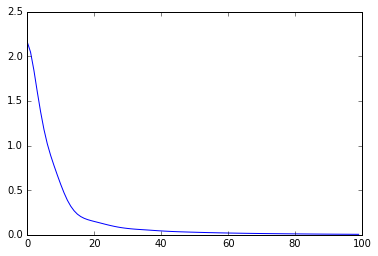

In [141]:
plt.plot(losses)

(array([  2.,   7.,  24.,  49.,  42.,  57.,  42.,  45.,  19.,   9.]),
 array([-1.51713049, -1.2384743 , -0.9598181 , -0.6811619 , -0.40250571,
        -0.12384951,  0.15480669,  0.43346288,  0.71211908,  0.99077528,
         1.26943147]),
 <a list of 10 Patch objects>)

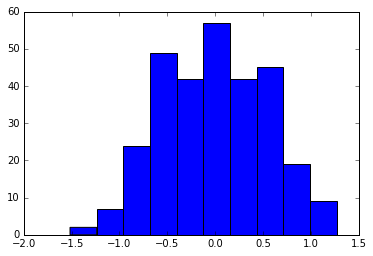

In [143]:
plt.hist(sess.run(weights)[:, 1])

In [148]:
sess.run(bias)

array([-5.50573206, -5.80927515, -5.70845461, -6.09327555, -5.8724699 ,
       -5.36014175, -4.88062239, -5.45234919], dtype=float32)

In [144]:
m = sess.run(margins, feed_dict = data_dict)

In [145]:
pred = m.argmax(axis=1)

In [146]:
label_batch[:, 2] == 2*(pred == 2) - 1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [880]:
class BatchReader(object):
    
    def __init__(self, data_dict, batch_size, shuffle=True, shuffle_seed=0, pad=True):
        self.data_dict = data_dict        
        self.batch_size = batch_size
        _k = data_dict.keys()[0]
        self.data_length = data_dict[_k].shape[0]
        self.total_batches = (self.data_length - 1) // self.batch_size + 1
        self.curr_batch_num = 0
        self.curr_epoch = 1
        self.pad = pad
        self.shuffle=shuffle
        self.shuffle_seed=shuffle_seed
        
        if self.shuffle:
            self.rng = np.random.RandomState(seed=self.shuffle_seed)
            self.perm = self.rng.permutation(self.data_length)
        
    def __iter__(self):
        return self

    def next(self):
        return self.get_next_batch()
        
    def get_next_batch(self):
        data = self.get_batch(self.curr_batch_num)
        self.increment_batch_num()
        return data

    def increment_batch_num(self):
        m = self.total_batches
        if (self.curr_batch_num >= m - 1):
            self.curr_epoch += 1
            if self.shuffle:
                self.perm = self.rng.permutation(self.data_length)
        self.curr_batch_num = (self.curr_batch_num + 1) % m

    def get_batch(self, cbn):
        data = {}
        startv = cbn * self.batch_size
        endv = (cbn + 1) * self.batch_size
        if self.pad and endv > self.data_length:
            startv = self.data_length - self.batch_size
            endv = startv + self.batch_size

        for k in self.data_dict:
            if self.shuffle:
                data[k] = self.data_dict[k][self.perm[startv: endv]]
            else:
                data[k] = self.data_dict[k][startv: endv]

        return data



In [995]:
class tf_optimizer(object):

    def __init__(self, 
                 model_func,
                 model_kwargs,
                 loss_func, 
                 loss_kwargs,
                 batch_size,
                 train_iterations,
                 optimizer_class,
                 optimizer_args=(),
                 optimizer_kwargs=None,
                 sess=None,
                 train_shuffle=False
                 ):
                        
        self.model_func = model_func
        self.model_kwargs = model_kwargs
        self.loss_func = loss_func
        self.loss_kwargs = loss_kwargs
        self.train_shuffle=train_shuffle
        
        self.train_iterations = train_iterations
        self.batch_size = batch_size
     
        if sess is None:
            sess = tf.Session()
        self.sess = sess
                
        if optimizer_kwargs is None:
            optimizer_kwargs = {}
        self.optimizer = optimizer_class(*optimizer_args, 
                                         **optimizer_kwargs)
        
    def fit(self, train_data, train_labels):
        self.model, self.data_holder = self.model_func(**self.model_kwargs)
        self.loss, self.labels_holder = self.loss_func(self.model, **self.loss_kwargs)
        
        self.optimizer_op = self.optimizer.minimize(self.loss)
            
        data_dict = {self.data_holder: train_data,
                     self.labels_holder: train_labels}
        train_data = BatchReader(data_dict=data_dict,
                                 batch_size=self.batch_size,
                                 shuffle=self.train_shuffle,
                                 shuffle_seed=0,
                                 pad=True)
        
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        
        self.losses = []                      
        for i in range(self.train_iterations):
            data_batch = train_data.next()
            output = self.sess.run({'opt': self.optimizer_op,
                                    'loss': self.loss}, 
                                    feed_dict=data_batch)
            self.losses.append(output['loss'])
                
    def predict(self, test_data):
        data_dict = {self.data_holder: test_data}
        test_data = BatchReader(data_dict=data_dict,
                             batch_size=self.batch_size,
                             shuffle=False,
                             pad=False)                  
        preds = []
        for i in range(test_data.total_batches):
            data_batch = test_data.get_batch(i)
            pred_batch = self.sess.run(self.model, feed_dict=data_batch)
            preds.append(pred_batch)
        return np.row_stack(preds)


In [996]:
def binarize_labels(labels):
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    category_matrix = np.array([2 * (labels == c) - 1 for 
                                    c in unique_labels]).T.astype(int)
    return category_matrix, unique_labels
    

class tf_classifier(tf_optimizer):
    
    def fit(self, train_data, train_labels):
        num_features = train_data.shape[1]
        binarized_labels, classes_ = binarize_labels(train_labels)
        num_classes = len(classes_)
        
        self.model_kwargs['num_features'] = num_features
        self.model_kwargs['num_classes'] = num_classes
        self.classes_ = classes_
        super(tf_classifier, self).fit(train_data=train_data, 
                                       train_labels=binarized_labels)
  
    def decision_function(self, test_data):
        return super(tf_classifier, self).predict(test_data)
    
    def predict(self, test_data):
        preds = self.decision_function(test_data)
        preds = np.argmax(preds, axis=1)
        classes_ = self.classes_
        return classes_[preds]

In [1070]:
def linear_one_vs_all_classifier(num_features, num_classes):    
    initial_weights = tf.zeros(shape=(num_features, num_classes), dtype=tf.float32)
    weights = tf.Variable(initial_weights, 
                          dtype=tf.float32,
                          name='weights')
    initial_bias = tf.zeros(shape=(num_classes,))
    bias = tf.Variable(initial_bias, 
                       dtype=tf.float32,
                       name='bias')
                           
    data = tf.placeholder(shape=(None, num_features), dtype=tf.float32, name='data')
    margins = tf.add(tf.matmul(data, weights), bias, name='margins')
    return margins, data


def hinge_loss(margins):
    num_classes = margins.shape.as_list()[1]
    category_labels = tf.placeholder(shape=(None, num_classes),
                                     dtype=tf.float32, 
                                     name='labels')
    h = tf.maximum(0., 1 - category_labels * margins, name='hinge_loss')
    hinge_loss_mean = tf.reduce_mean(h, name='hinge_loss_mean')
    return hinge_loss_mean, category_labels

In [1071]:
cls = tf_classifier(model_func=linear_one_vs_all_classifier,
              model_kwargs={},
              loss_func=hinge_loss, 
              loss_kwargs={},
              batch_size=2500,
              train_iterations=1000,
              train_shuffle=True,
              optimizer_class=tf.train.MomentumOptimizer,
              optimizer_kwargs = {'learning_rate':10.,
                                  'momentum': 0.99
                                 },
              sess=sess,
              
              )

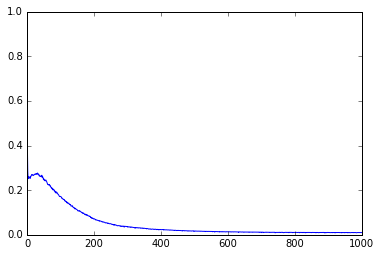

In [1072]:
data_ss = Neural_Data[var_levels=='V3']
categories_ss = categories[var_levels=='V3']
cls.fit(data_ss, categories_ss)
preds = cls.predict(data_ss)
margins = cls.decision_function(data_ss)
plt.plot(cls.losses)

In [1073]:
(preds == categories_ss).sum()

2554

In [1091]:
def hinge_loss_l2reg(margins, C):
    num_classes = margins.shape.as_list()[1]
    category_labels = tf.placeholder(shape=(None, num_classes),
                                     dtype=tf.float32, 
                                     name='labels')
    h = tf.maximum(0., 1 - category_labels * margins)
    weights = cls.model.op.inputs[0].op.inputs[1]

    reg_loss = 0.5*tf.reduce_mean(tf.square(weights)) 
    hinge_loss = tf.reduce_mean(h)
    total_loss = C * hinge_loss + reg_loss
    return total_loss, category_labels

In [1092]:
cls = tf_classifier(model_func=linear_one_vs_all_classifier,
              model_kwargs={},
              loss_func=hinge_loss_l2reg, 
              loss_kwargs={'C':1},
              batch_size=2500,
              train_iterations=1000,
              train_shuffle=True,
              optimizer_class=tf.train.MomentumOptimizer,
              optimizer_kwargs = {'learning_rate':10.,
                                  'momentum': 0.99
                                 },
              sess=sess,
              
              )

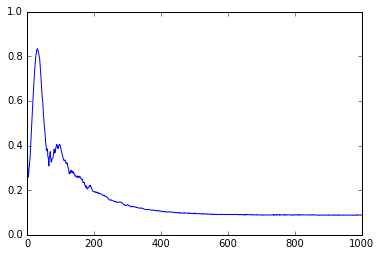

In [1093]:
data_ss = Neural_Data[var_levels=='V3']
categories_ss = categories[var_levels=='V3']
cls.fit(data_ss, categories_ss)
preds = cls.predict(data_ss)
margins = cls.decision_function(data_ss)
plt.plot(cls.losses)

In [1097]:
import cross_validation as cv


In [1098]:
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())


In [1126]:
splits = cv.get_splits(meta_array, 
              lambda x: x['object_name'],  #we're balancing splits by object
              5,  
              5,  
              35,  
              train_filter=lambda x: (x['variation_level'] == 'V3'),
              test_filter=lambda x: (x['variation_level'] == 'V3'),)
    
    
model_args={'model_func': linear_one_vs_all_classifier,
            'model_kwargs': {},
            'loss_func': hinge_loss_l2reg, 
            'loss_kwargs': {'C':5e-3},
            'batch_size': 2500,
            'train_iterations': 1000,
            'train_shuffle': True,
            'optimizer_class':tf.train.MomentumOptimizer,
            'optimizer_kwargs': {'learning_rate':.1,
                                 'momentum': 0.9
                                 },
            'sess': sess}

res = train_and_test_scikit_classifier(features=Neural_Data,
                                       labels=categories,
                                       splits=splits,
                                       model_class=tf_classifier,
                                       model_args=model_args)


In [1127]:
res[0]['test']['mean_accuracy']

0.791875